# Computing on the GPU

This example will go through how to use the GPU for computing dose-fluence matrices and dose.

In [1]:
using Pkg; Pkg.activate("."); Pkg.develop(path="..")
using DoseCalculations
using Plots, StaticArrays, CUDA

  Activating project at `~/Code/DoseCalculations.jl/examples`


## Setup

First, we'll set up a simple water tank phantom,

In [2]:
depth = 0.:2.:400
x = -200.:2.:200.
pos = SVector.(x, 0., -depth');

a set of beamlets,

In [3]:
fieldsize = 100.
SAD = 1000.
SSD = SAD

xb = -0.5*fieldsize:5:0.5*fieldsize
bixels = BixelGrid(xb, xb)

gantry = GantryPosition(0., 0., SAD)
beamlets = Beamlet.(bixels, (gantry,));

the dose calculation and the external surface,

In [4]:
calc = FinitePencilBeamKernel("/path/to/kernel-data.jld")
MU = 1. # We'll calibrate such that 1MU=1Gy at max for simplicity
calibrate!(calc, MU, fieldsize, SSD)

surf = PlaneSurface(SSD);

*Note:* only `PlaneSurface` is currently supported for GPU.

## Computing on the GPU

To compute a dose-fluence matrix on the GPU, we move the data onto GPU memory using `cu`,

In [5]:
pos = cu(pos);
beamlets = cu(beamlets)
surf = cu(surf)
calc = cu(calc);

Then we compute the dose-fluence matrix `D`,

In [6]:
CUDA.@sync D = dose_fluence_matrix(CuArray, pos, beamlets, surf, calc);

The first time you run the above cell will take a while as it includes the compile time.
Subsequent runs should run *much* faster!

Next, we'll compute the dose.
We'll create a fluence map, then multiply it by the dose-fluence matrix,

In [7]:
Ψ = CUDA.fill(1., size(beamlets));
CUDA.@sync dose = D*vec(Ψ);

The data as to be moved back to the CPU to plot,

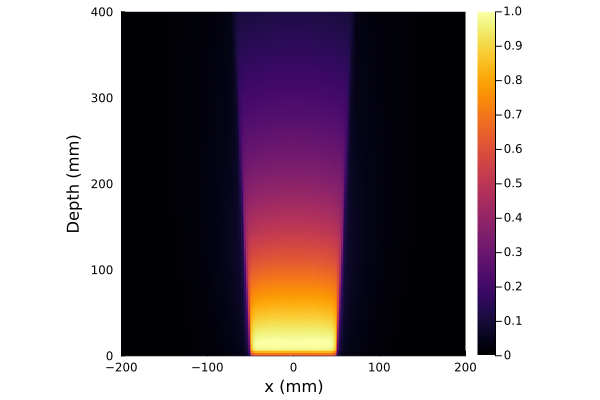

In [8]:
function plot_dose(dose)
        dose_cpu = Array(dose) # Moves back to the CPU
        heatmap(x, depth, reshape(dose_cpu, size(pos))',
                xlim=x[[1,end]], ylim=depth[[1,end]], aspect_ratio=1,
                xlabel="x (mm)", ylabel="Depth (mm)", clim=(0, 1), fmt=:png)
end
plot_dose(dose)

To shape the dose, the fluence weights ($\Psi$) are modified.
Here, we choose a random selection of weights

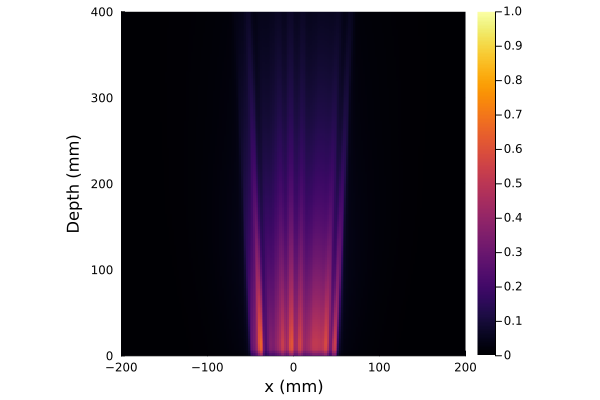

In [9]:
Ψ = cu(rand(size(beamlets)...))
CUDA.@sync dose = D*vec(Ψ);
plot_dose(dose)